Import Libraries

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet as wn
import torch
from deepmultilingualpunctuation import PunctuationModel
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from transformers import pipeline

nltk.download('punkt')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to

True

Combine Transcripts from Multiple .TXT files

In [2]:
# Folder containing raw transcripts
base_folder = "1_raw_data/debate"
all_data = []

for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    transcript = f.read().strip()

                    # Extract metadata from filename
                    match = re.match(r"([a-zA-Z]+)_(\d+)_([a-zA-Z\-]+)_(pro|con)", file)
                    if match:
                        debater_name = match.group(1)
                        debate_id = match.group(2)
                        topic = match.group(3)
                        stance = match.group(4)
                    else:
                        debater_name = "unknown"
                        debate_id = "unknown"
                        topic = "unknown"
                        stance = "unknown"

                    # Count word length using nltk tokenizer
                    word_count = len(word_tokenize(transcript))

                    # Append to list
                    all_data.append({
                        "filename": file,
                        "debate_id": debate_id,
                        "debater_name": debater_name,
                        "topic": topic,
                        "stance": stance,
                        "transcript": transcript,
                        "transcript_length": word_count
                    })

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

df = pd.DataFrame(all_data)
df.head()

,filename,debate_id,debater_name,topic,stance,transcript,transcript_length
0,AM_101_affirmativeaction_pro.trs.txt,101,AM,affirmativeaction,pro,The motion before us is this house would suppo...,1342
1,AM_381_monarchy_pro.trs.txt,381,AM,monarchy,pro,In this speech I'm going to argue to you that ...,1261
2,AM_602_schoolvouchers_pro.trs.txt,602,AM,schoolvouchers,pro,The motion before us is that this house would ...,1346
3,DJ_121_ban-boxing_pro.trs.txt,121,DJ,ban-boxing,pro,We should ban boxing because boxing is a blood...,689
4,DJ_1_ban-video-games_pro.trs.txt,1,DJ,ban-video-games,pro,We should ban the sale of violent video games ...,592


Transcript EDA and Processing

In [3]:
# Dataset Info
print("\033[94m\n--- Dataset Info ---\033[0m")
print(df.info())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   filename           4422 non-null   object
 1   debate_id          4422 non-null   object
 2   debater_name       4422 non-null   object
 3   topic              4422 non-null   object
 4   stance             4422 non-null   object
 5   transcript         4422 non-null   object
 6   transcript_length  4422 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 242.0+ KB
None


In [4]:
# Check for 'unknown' values in key metadata columns
print("\033[94m\n--- Count of 'unknown' in Key Columns ---\033[0m")
for col in ['debate_id', 'debater_name', 'topic', 'transcript']:
    count = (df[col] == 'unknown').sum()
    print(f"{col}: {count} row(s) with 'unknown'")


--- Count of 'unknown' in Key Columns ---
debate_id: 0 row(s) with 'unknown'
debater_name: 0 row(s) with 'unknown'
topic: 0 row(s) with 'unknown'
transcript: 0 row(s) with 'unknown'


In [5]:
# Check for duplicate filenames
print("\033[94m\n--- Duplicate Check ---\033[0m")
duplicate_count = df.duplicated(subset='filename', keep=False).sum()
duplicate_transcript_count = df.duplicated(subset='transcript', keep=False).sum()
print(f"Duplicate filenames found: {duplicate_count}")
print(f"Duplicate transcript found: {duplicate_transcript_count}")


--- Duplicate Check ---
Duplicate filenames found: 458
Duplicate transcript found: 931


In [6]:
# Remove duplicates for clean analysis
df_unique = df.drop_duplicates(subset='filename', keep='first')
df_unique = df.drop_duplicates(subset='transcript', keep='first')

In [7]:
# Category distributions
print("\033[94m\n--- Unique Debate ID Counts ---\033[0m")
print(df_unique['debate_id'].value_counts())

print("\033[94m\n--- Unique Debater Name Counts ---\033[0m")
print(df_unique['debater_name'].value_counts())

print("\033[94m\n--- Unique Topic Counts ---\033[0m")
print(df_unique['topic'].value_counts())


--- Unique Debate ID Counts ---
debate_id
2480    23
3194    22
3166    22
61      22
2143    22
        ..
4009     1
4147     1
4354     1
4362     1
1246     1
Name: count, Length: 442, dtype: int64

--- Unique Debater Name Counts ---
debater_name
TL        717
JL        674
RG        635
SSH       451
DJ        406
WS        398
YBA       188
EH         96
HE         65
james      49
will       40
tim        29
rachel     26
yaar       20
daniel     20
sam         9
YB          6
SF          5
SN          5
hayah       4
DZ          3
AM          3
eitan       2
Name: count, dtype: int64

--- Unique Topic Counts ---
topic
racial-profiling           35
recall-elections           30
television                 29
nationalism                26
stem-cell                  25
                           ..
minority-groups             1
sustainable-development     1
privatization               1
athletes                    1
planned-parenthood          1
Name: count, Length: 401, dtype: in

C:\Users\user\AppData\Local\Temp\ipykernel_11116\740373965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_unique, x='stance', palette='Set2')


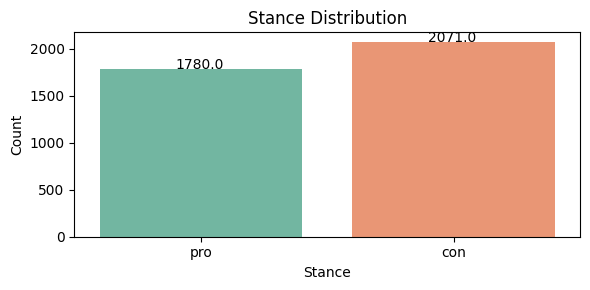

In [8]:
# Stance distribution plot
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df_unique, x='stance', palette='Set2')
for bar in ax.patches:
    ax.annotate(f"{bar.get_height()}", (bar.get_x() + 0.3, bar.get_height() + 5))
plt.title("Stance Distribution")
plt.xlabel("Stance")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

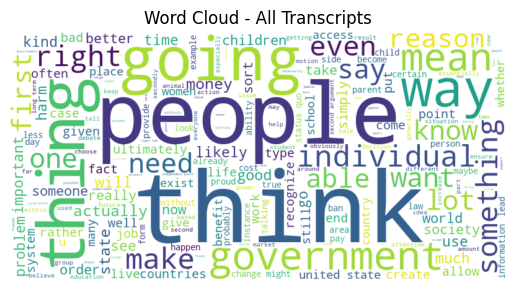

In [9]:
# Word Cloud – All transcripts
text_all = " ".join(df_unique['transcript'].astype(str))
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(text_all)
plt.figure(figsize=(6, 3))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - All Transcripts")
plt.tight_layout()
plt.show()

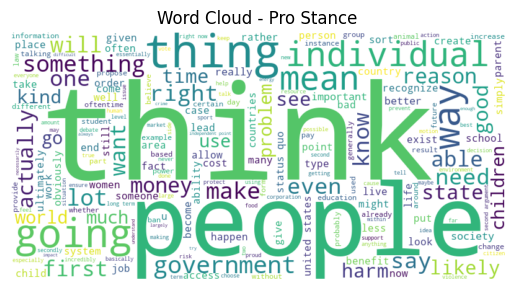

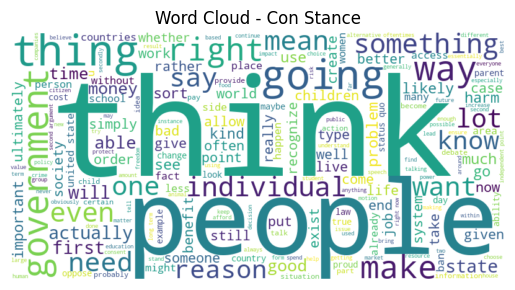

In [10]:
# Word Cloud – Pro vs Con
text_pro = " ".join(df_unique[df_unique['stance'] == 'pro']['transcript'])
text_con = " ".join(df_unique[df_unique['stance'] == 'con']['transcript'])

wordcloud_pro = WordCloud(width=800, height=400, background_color='white').generate(text_pro)
wordcloud_con = WordCloud(width=800, height=400, background_color='white').generate(text_con)

plt.figure(figsize=(6, 3))
plt.imshow(wordcloud_pro, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Pro Stance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.imshow(wordcloud_con, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Con Stance")
plt.tight_layout()
plt.show()

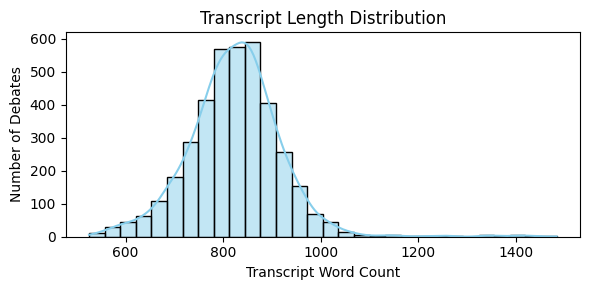

In [11]:
# Histogram – Transcript Length
plt.figure(figsize=(6, 3))
sns.histplot(df_unique['transcript_length'], bins=30, kde=True, color='skyblue')
plt.title("Transcript Length Distribution")
plt.xlabel("Transcript Word Count")
plt.ylabel("Number of Debates")
plt.tight_layout()
plt.show()

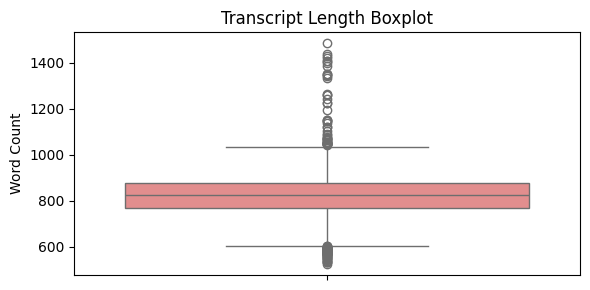

In [12]:
# Boxplot – Transcript Length
plt.figure(figsize=(6, 3))
sns.boxplot(y=df_unique['transcript_length'], color='lightcoral')
plt.title("Transcript Length Boxplot")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

In [13]:
# Calculate IQR to detect outliers in transcript_length
Q1 = df_unique['transcript_length'].quantile(0.25)
Q3 = df_unique['transcript_length'].quantile(0.75)
print(f"Q1:{Q1}, Q3:{Q3}")
IQR = Q3 - Q1
print(f"IQR:{IQR}")

# Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = df_unique[(df_unique['transcript_length'] >= lower_bound) & (df_unique['transcript_length'] <= upper_bound)]

Q1:768.0, Q3:878.0
IQR:110.0


In [14]:
# Drop weak columns
df_drop = df_filtered.drop(["debate_id", "debater_name", "topic"], axis=1)
df = df_drop

df.head()

,filename,stance,transcript,transcript_length
3,DJ_121_ban-boxing_pro.trs.txt,pro,We should ban boxing because boxing is a blood...,689
5,DJ_21_one-child_pro.trs.txt,pro,The one child policy brought more good than ha...,947
6,DJ_482_tobacco_pro.trs.txt,pro,We should absolutely not subsidize the cultiva...,782
7,DJ_644_year-round-schooling_pro.trs.txt,pro,Year round schooling will bring more good than...,843
8,DJ_681_ip-rights_pro.trs.txt,pro,We should abolish intellectual property rights...,792


Expand to Sentences

In [15]:
# Use nltk to initially split transcripts into sentences
sentence_data = []
for _, row in df.iterrows():
    transcript = str(row["transcript"]).strip()
    nltk_sentences = sent_tokenize(transcript)

    for i, sentence in enumerate(nltk_sentences, start=1):
        sentence_data.append({
            "filename": row["filename"],
            "stance": row["stance"],
            "sentence": sentence.strip(),
            "sentence_order": i,
            "sentence_length": len(sentence.strip().split())
        })

sentence_df = pd.DataFrame(sentence_data)

Sentence EDA and Processing

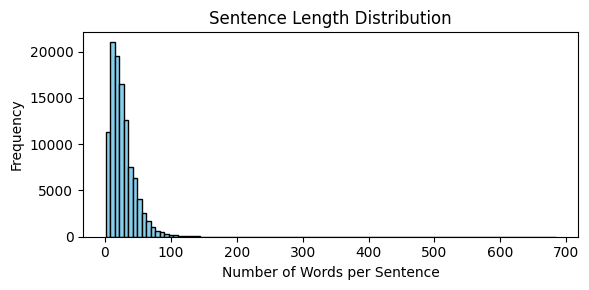

In [16]:
# Plot histogram of sentence lengths
plt.figure(figsize=(6, 3))
plt.hist(sentence_df["sentence_length"], bins=100, color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

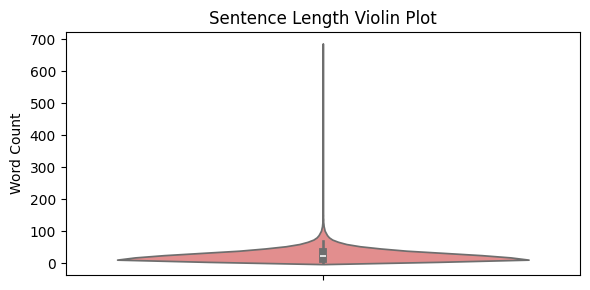

In [17]:
# Plot violin plot of Sentence Length
plt.figure(figsize=(6, 3))
sns.violinplot(y=sentence_df    ['sentence_length'], color='lightcoral')
plt.title("Sentence Length Violin Plot")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

In [18]:
# Sort sentence_length to find longest and shortest
longest = sentence_df.sort_values(by="sentence_length", ascending=False).head(2)
shortest = sentence_df.sort_values(by="sentence_length", ascending=True).head(5)

# Print outliers results
for idx, row in longest.iterrows():
    print(f"\nFilename: {row['filename']}\n"
          f"Sentence Length: {row['sentence_length']} words\n"
          f"Sentence: {row['sentence']}")

for idx, row in shortest.iterrows():
    print(f"\nFilename: {row['filename']}\n"
          f"Sentence Length: {row['sentence_length']} word(s)\n"
          f"Sentence: {row['sentence']}")


Filename: SSH_3232_pride-parades_con_opening_RG.trs.txt
Sentence Length: 684 words
Sentence: I stand in firm opposition to the motion we should cancel pride parades pride parades are an essential tool for individuals who are not in the mainstream in terms of gender sexuality to come together in solidarity and empower one another ultimately pride parades are the decisions of the people who have faced this sort of expression and as such the rights should not be abridged to that and I have three arguments but first some brief about all my opponent spends most of their speech focusing on the fact that pride parades are a target for hateful groups they say that if we allow this target to exist then violence will occur because people will act out against them so to responses first there are hundreds of targets around the world around it honestly even just the state of massachusetts which are worse than pride parades pride parades are a terrible spot for a terror or heat attack because indiv

In [19]:
# IQR to identify long sentences
Q1 = sentence_df['sentence_length'].quantile(0.25)
Q3 = sentence_df['sentence_length'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print(f"Upper Bound:{upper_bound}")

Upper Bound:68.0


In [20]:
# Restore punctuation for long sentences
model = PunctuationModel()

keywords = ["should", "because", "think", "believe", "must", "argue"]
processed_sentences = []

for _, row in sentence_df.iterrows():
    sentence = row['sentence']
    sentence_length = row['sentence_length']

    if sentence_length > upper_bound:
        # Restore punctuation and segment again
        try:
            restored = model.restore_punctuation(sentence)
            split_sentences = sent_tokenize(restored)
        except Exception as e:
            print(f"Error restoring punctuation for: {sentence[:50]}... | {e}")
            split_sentences = [sentence]
    else:
        split_sentences = [sentence]

    for s in split_sentences:
        s = s.strip()
        word_count = len(s.split())
        if word_count < 5 and not any(k in s.lower() for k in keywords):
            continue
        processed_sentences.append({
            "filename": row["filename"],
            "stance": row["stance"],
            "sentence": s,
            "sentence_order": -1,  # placeholder
            "sentence_length": word_count
        })

# Assign sentence order per filename
sentence_df = pd.DataFrame(processed_sentences)
sentence_df["sentence_order"] = sentence_df.groupby("filename").cumcount() + 1

Device set to use cuda:0
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\token_classification.py:186: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.NONE"` instead.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [21]:
# Print the processed sentences for the problem transcript
target_file = "SSH_3232_pride-parades_con_opening_RG.trs.txt"
subset = sentence_df[sentence_df["filename"] == target_file].sort_values("sentence_order")

print("Order: Content")
for _, row in subset.iterrows():
    print(f"{row['sentence_order']}: {row['sentence']}")

Order: Content
1: I stand in firm opposition to the motion.
2: we should cancel pride parades.
3: pride parades are an essential tool for individuals who are not in the mainstream in terms of gender sexuality to come together in solidarity and empower one another.
4: ultimately, pride parades are the decisions of the people who have faced this sort of expression and, as such, the rights should not be abridged to that.
5: and I have three arguments.
6: but first some brief about.
7: all my opponent spends most of their speech focusing on the fact that pride parades are a target for hateful groups.
8: they say that if we allow this target to exist, then violence will occur because people will act out against them.
9: first, there are hundreds of targets around the world- around it, honestly, even just the state of massachusetts- which are worse than pride parades.
10: pride parades are a terrible spot for a terror or heat attack because individuals can run away in numerous directions.
11

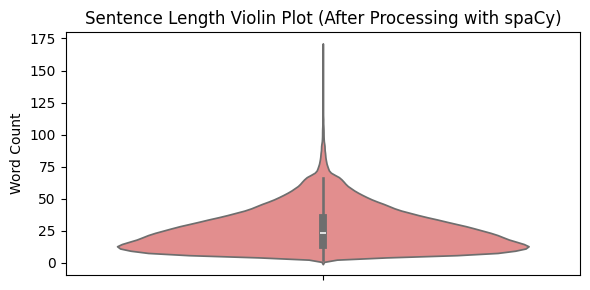

In [22]:
# Plot histogram of sentence lengths
plt.figure(figsize=(6, 3))
sns.violinplot(y=sentence_df['sentence_length'], color='lightcoral')
plt.title("Sentence Length Violin Plot (After Processing with spaCy)")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

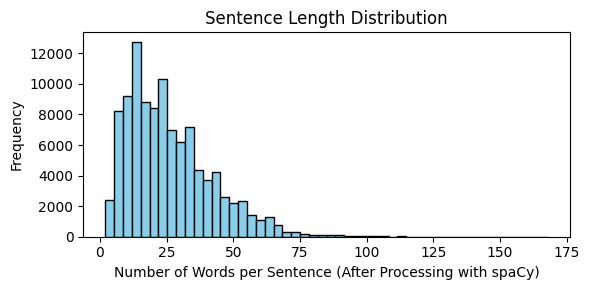

In [23]:
# Plot violin plot of Sentence Length
plt.figure(figsize=(6, 3))
plt.hist(sentence_df["sentence_length"], bins=50, color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence (After Processing with spaCy)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [24]:
# Sort sentence_length to find longest and shortest
longest = sentence_df.sort_values(by="sentence_length", ascending=False).head(1)

# Loop through the longest sentences and show the raw transcript for each
for idx, row in longest.iterrows():
    filename = row['filename']
    print(f"\nFilename: {filename}")
    print(f"Sentence Length: {row['sentence_length']} words")
    print("Processed Sentence:")
    print(row['sentence'])

    # Get the original transcript for comparison
    original_row = df[df['filename'] == filename]
    if not original_row.empty:
        raw_transcript = original_row.iloc[0]["transcript"]
        print("\nOriginal Transcript (Before Processing):")
        print(raw_transcript.strip())
    else:
        print("\nOriginal transcript not found.")


Filename: DJ_3238_palestinian-independence_con_TL_implicit.trs.txt
Sentence Length: 168 words
Processed Sentence:
There's only limited political autonomy for the actual people, and the reason for that is because they're worried about terrorism or even more radical groups taking over, and I think that the clearest examples of this are in gaza, where, after the israelis withdrew in the early two thousands out of gaza out of hopes that this would help spark peace, renewed peace agreements and viability of a palestinian state, the result is that fair elections, election- well, no elections were held and radical groups like hamas were able to leverage antisemitism, sectional fears and also scare tactics like threatening opponents and using violence and intimidation- voter intimidation and also candidate intimidation- as a means by which to essentially monopolize the levers of government in gaza, and ultimately, that led to a huge destabilization region where it became much more poor, much 

In [25]:
# Define discourse-based splitter
def discourse_split(text):
    text = re.sub(r'\s+', ' ', text).strip()
    cues = [
        r'\band we think that\b',
        r'\bwe think that\b',
        r'\bthe reason for this is that\b',
        r'\bthis means that\b',
        r'\bwhat this means is that\b',
        r'\bthis is why\b',
        r'\bfinally\b',
        r'\bfirst\b', r'\bsecond\b', r'\bthird\b',
        r'\bone\b', r'\btwo\b', r'\bthree\b',
        r'\bbut\b', r'\bso\b', r'\bbecause\b'
    ]
    for cue in cues:
        text = re.sub(cue, r'. \g<0>', text, flags=re.IGNORECASE)
    return [s.strip() for s in re.split(r'\.\s*', text) if len(s.strip().split()) >= 5]


In [26]:
# Process
new_sentences = []

for _, row in sentence_df.iterrows():
    sentence = row['sentence']
    length = row['sentence_length']

    # Only apply splitting if sentence exceeds upper bound
    if length > upper_bound:
        split_sentences = discourse_split(sentence)
    else:
        split_sentences = [sentence]

    for s in split_sentences:
        s = s.strip()
        word_count = len(s.split())
        if word_count < 5 and not any(k in s.lower() for k in keywords):
            continue
        new_sentences.append({
            "filename": row["filename"],
            "stance": row["stance"],
            "sentence": s,
            "sentence_length": word_count,
            "sentence_order": -1  # Will be reassigned
        })

# Reassign sentence order
final_df = pd.DataFrame(new_sentences)
final_df["sentence_order"] = final_df.groupby("filename").cumcount() + 1

In [27]:
# Stats summary after processing
min_len = final_df["sentence_length"].min()
max_len = final_df["sentence_length"].max()
avg_len = final_df["sentence_length"].mean()
Q1 = final_df["sentence_length"].quantile(0.25)
Q3 = final_df["sentence_length"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print("\nSentence Length Statistics (After Splitting):")
print(f"Min: {min_len} words")
print(f"Max: {max_len} words")
print(f"Average: {avg_len:.2f} words")
print(f"IQR: {IQR} (Q1: {Q1}, Q3: {Q3})")
print(f"Upper Bound (Q3 + 1.5*IQR): {upper_bound}")


Sentence Length Statistics (After Splitting):
Min: 2 words
Max: 127 words
Average: 25.48 words
IQR: 22.0 (Q1: 13.0, Q3: 35.0)
Upper Bound (Q3 + 1.5*IQR): 68.0


In [28]:
final_df.head(10)

,filename,stance,sentence,sentence_length,sentence_order
0,DJ_121_ban-boxing_pro.trs.txt,pro,We should ban boxing because boxing is a blood...,26,1
1,DJ_121_ban-boxing_pro.trs.txt,pro,So why is this true?,5,2
2,DJ_121_ban-boxing_pro.trs.txt,pro,The first big thing is that boxing has horrifi...,17,3
3,DJ_121_ban-boxing_pro.trs.txt,pro,It's essentially like a modern day equivalent ...,16,4
4,DJ_121_ban-boxing_pro.trs.txt,pro,In the short term you see things like concussi...,32,5
5,DJ_121_ban-boxing_pro.trs.txt,pro,There's all kinds of horrific injuries that pe...,14,6
6,DJ_121_ban-boxing_pro.trs.txt,pro,A lot of those injuries specifically can also ...,12,7
7,DJ_121_ban-boxing_pro.trs.txt,pro,Obviously you can suffer long term nerve damag...,16,8
8,DJ_121_ban-boxing_pro.trs.txt,pro,This is a big problem in sports like boxing an...,19,9
9,DJ_121_ban-boxing_pro.trs.txt,pro,And this can result in essentially dementia li...,14,10


In [29]:
# Sentence count per transcript by filename
sentence_counts = final_df.groupby("filename")["sentence_order"].max().reset_index(name="total_sentences")
print("\033[94m--- Sentence Count per Transcript ---\033[0m")
print(sentence_counts.describe())

# Compare average number of sentences between stances
stance_sentence_counts = final_df.groupby(["filename", "stance"])["sentence_order"].max().reset_index()
avg_by_stance = stance_sentence_counts.groupby("stance")["sentence_order"].mean()
print("\033[94m--- Average Sentence Count by Stance ---\033[0m")
print(avg_by_stance)

--- Sentence Count per Transcript ---
       total_sentences
count      3738.000000
mean         29.034778
std           4.736613
min          16.000000
25%          26.000000
50%          29.000000
75%          32.000000
max          56.000000
--- Average Sentence Count by Stance ---
stance
con    29.169525
pro    28.872717
Name: sentence_order, dtype: float64


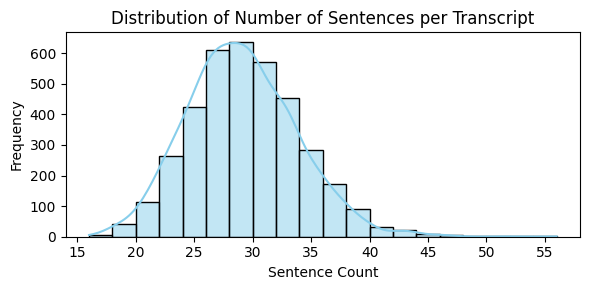

In [30]:
# Plot distribution of number of sentences per transcript
plt.figure(figsize=(6, 3))
sns.histplot(data=sentence_counts, x="total_sentences", bins=20, kde=True, color="skyblue")
plt.title("Distribution of Number of Sentences per Transcript")
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11116\402900748.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_by_stance.index, y=avg_by_stance.values, palette="Set2")


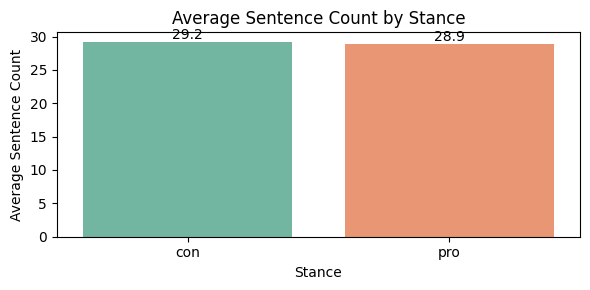

In [31]:
# Plot average sentence count by stance
plt.figure(figsize=(6, 3))
ax = sns.barplot(x=avg_by_stance.index, y=avg_by_stance.values, palette="Set2")
plt.title("Average Sentence Count by Stance")
plt.ylabel("Average Sentence Count")
plt.xlabel("Stance")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [32]:
# Save Dataset
final_df.to_csv("2_processed_data/processed_dataset.csv", index=False)

Further Text Exploration

In [33]:
# Initialize stopwords and lemmatizer
df = final_df.copy()

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# POS tag mapping function (Penn Treebank → WordNet)
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    cleaned = []

    for word, tag in tagged_tokens:
        if word.isalpha() and word not in stop_words:
            wn_tag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, wn_tag)
            cleaned.append(lemma)

    return cleaned

# Apply preprocessing
df["tokenized_sentence"] = df["sentence"].apply(preprocess_text)

df.head(10)

,filename,stance,sentence,sentence_length,sentence_order,tokenized_sentence
0,DJ_121_ban-boxing_pro.trs.txt,pro,We should ban boxing because boxing is a blood...,26,1,"[ban, boxing, boxing, blood, sport, absolutely..."
1,DJ_121_ban-boxing_pro.trs.txt,pro,So why is this true?,5,2,[true]
2,DJ_121_ban-boxing_pro.trs.txt,pro,The first big thing is that boxing has horrifi...,17,3,"[first, big, thing, box, horrific, consequence..."
3,DJ_121_ban-boxing_pro.trs.txt,pro,It's essentially like a modern day equivalent ...,16,4,"[essentially, like, modern, day, equivalent, g..."
4,DJ_121_ban-boxing_pro.trs.txt,pro,In the short term you see things like concussi...,32,5,"[short, term, see, thing, like, concussion, se..."
5,DJ_121_ban-boxing_pro.trs.txt,pro,There's all kinds of horrific injuries that pe...,14,6,"[kind, horrific, injury, people, obtain, short..."
6,DJ_121_ban-boxing_pro.trs.txt,pro,A lot of those injuries specifically can also ...,12,7,"[lot, injury, specifically, also, long, term, ..."
7,DJ_121_ban-boxing_pro.trs.txt,pro,Obviously you can suffer long term nerve damag...,16,8,"[obviously, suffer, long, term, nerve, damage,..."
8,DJ_121_ban-boxing_pro.trs.txt,pro,This is a big problem in sports like boxing an...,19,9,"[big, problem, sport, like, boxing, also, foot..."
9,DJ_121_ban-boxing_pro.trs.txt,pro,And this can result in essentially dementia li...,14,10,"[result, essentially, dementia, like, trait, h..."


In [34]:
# N-gram Plot Function
def plot_ngrams(corpus, ngram_range=(1, 1), n=20, title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    top_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    if top_words:
        words, counts = zip(*top_words)
        plt.figure(figsize=(6, 3))
        ax = sns.barplot(x=list(counts), y=list(words), palette="crest")
        for i, v in enumerate(counts):
            ax.text(v + 1, i, str(v), color='black', va='center')
        plt.title(title)
        plt.xlabel("Frequency")
        plt.ylabel("N-gram")
        plt.tight_layout()
        plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11116\1324578328.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts), y=list(words), palette="crest")


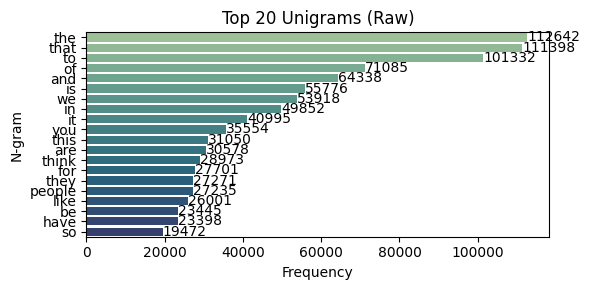

C:\Users\user\AppData\Local\Temp\ipykernel_11116\1324578328.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts), y=list(words), palette="crest")


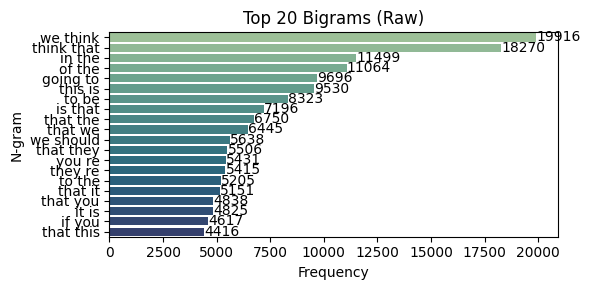

C:\Users\user\AppData\Local\Temp\ipykernel_11116\1324578328.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts), y=list(words), palette="crest")


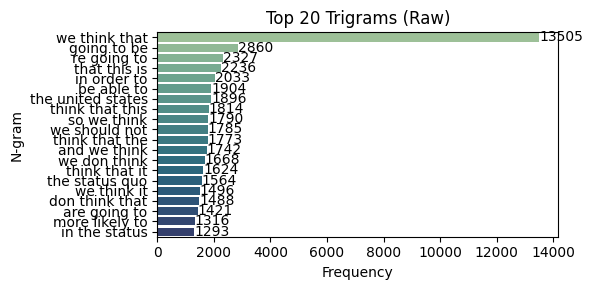

In [35]:
# N-grams BEFORE stopword removal (raw sentence)
plot_ngrams(df["sentence"], (1, 1), 20, "Top 20 Unigrams (Raw)")
plot_ngrams(df["sentence"], (2, 2), 20, "Top 20 Bigrams (Raw)")
plot_ngrams(df["sentence"], (3, 3), 20, "Top 20 Trigrams (Raw)")

C:\Users\user\AppData\Local\Temp\ipykernel_11116\1324578328.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts), y=list(words), palette="crest")


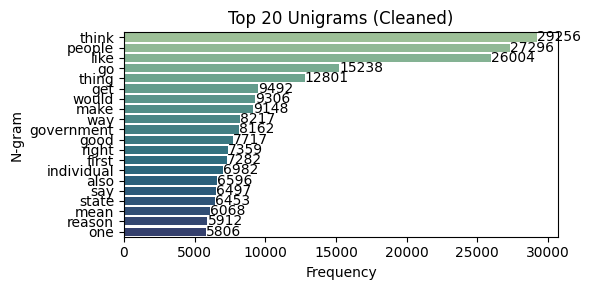

C:\Users\user\AppData\Local\Temp\ipykernel_11116\1324578328.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts), y=list(words), palette="crest")


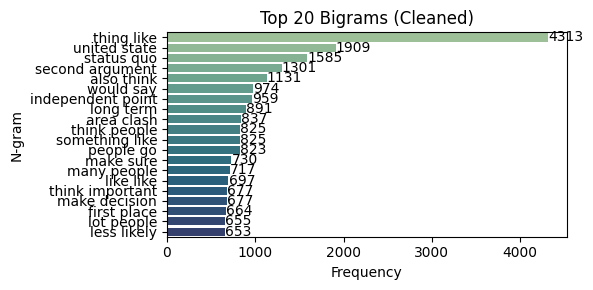

C:\Users\user\AppData\Local\Temp\ipykernel_11116\1324578328.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(counts), y=list(words), palette="crest")


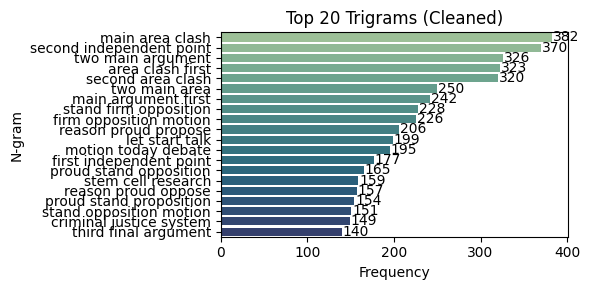

In [36]:
# Join tokens into strings
df["joined_tokens"] = df["tokenized_sentence"].apply(lambda x: " ".join(x))
df = df[df["joined_tokens"].str.strip() != ""]

# N-grams AFTER stopword removal (joined_tokens)
plot_ngrams(df["joined_tokens"], (1, 1), 20, "Top 20 Unigrams (Cleaned)")
plot_ngrams(df["joined_tokens"], (2, 2), 20, "Top 20 Bigrams (Cleaned)")
plot_ngrams(df["joined_tokens"], (3, 3), 20, "Top 20 Trigrams (Cleaned)")

C:\Users\user\AppData\Local\Temp\ipykernel_11116\2531789921.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(freqs), y=list(words), palette="Set2")


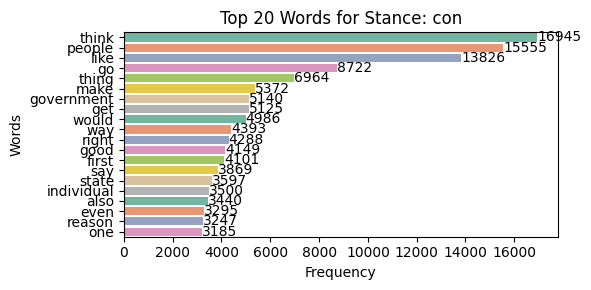

C:\Users\user\AppData\Local\Temp\ipykernel_11116\2531789921.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(freqs), y=list(words), palette="Set2")


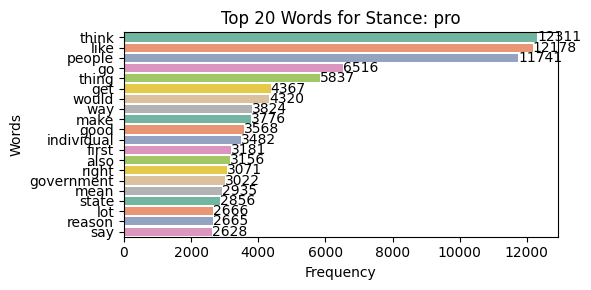

In [37]:
# Top Words by STANCE
def top_words_by_stance(df, stance_col, token_col, top_n=20):
    stance_groups = df.groupby(stance_col)[token_col]
    for stance, tokens in stance_groups:
        all_words = [word for sublist in tokens for word in sublist]
        top_words = Counter(all_words).most_common(top_n)

        if top_words:
            words, freqs = zip(*top_words)
            plt.figure(figsize=(6, 3))
            ax = sns.barplot(x=list(freqs), y=list(words), palette="Set2")
            for i, v in enumerate(freqs):
                ax.text(v + 1, i, str(v), color='black', va='center')
            plt.title(f"Top {top_n} Words for Stance: {stance}")
            plt.xlabel("Frequency")
            plt.ylabel("Words")
            plt.tight_layout()
            plt.show()

# If stance column exists
if "stance" in df.columns:
    top_words_by_stance(df, "stance", "tokenized_sentence")


Fallacies Labelling Pipeline Validation

In [ ]:
# Initialize the model pipeline
model_path = "q3fer/distilbert-base-fallacy-classification"

pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    device=0 if torch.cuda.is_available() else -1,
    torch_dtype=None
)

# Create columns first with default empty values
df["fallacy"] = ""
df["fallacy_score"] = 0.0

# Loop through each sentence and assign predicted label and score
for idx, text in enumerate(df["sentence"]):
    result = pipe(text)
    df.at[idx, "fallacy"] = result[0]['label']
    df.at[idx, "fallacy_score"] = result[0]['score']

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at q3fer/distilbert-base-fallacy-classification were not used when initializing TFDistilBertForSequenceClassification: ['dropout_179']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at q3fer/distilbert-base-fallacy-classification and a

In [39]:
# Apply confidence threshold
threshold = 0.7
df["fallacy"] = df.apply(lambda row: row["fallacy"] if row["fallacy_score"] >= threshold else "no_fallacy", axis=1)

# Count fallacy types and calculate average score
fallacy_counts = df["fallacy"].value_counts().reset_index()
fallacy_counts.columns = ["fallacy", "count"]

fallacy_scores = df.groupby("fallacy")["fallacy_score"].mean().reset_index()
fallacy_scores.columns = ["fallacy", "avg_score"]

# Merge count and score data
fallacy_stats = pd.merge(fallacy_counts, fallacy_scores, on="fallacy")
fallacy_stats = fallacy_stats.sort_values(by="count", ascending=False)

print(fallacy_stats)

                   fallacy  count  avg_score
0               no_fallacy  75257   0.464710
1    faulty generalization  12553   0.869168
2       circular reasoning   6119   0.837487
3         fallacy of logic   4111   0.805256
4        appeal to emotion   2506   0.808749
5     fallacy of relevance   1906   0.783820
6     fallacy of extension   1431   0.836866
7   fallacy of credibility   1297   0.771160
8            false dilemma   1140   0.866039
9               ad populum    865   0.858530
10         false causality    862   0.828288
11              ad hominem    359   0.830905
12             intentional    125   0.788269


C:\Users\user\AppData\Local\Temp\ipykernel_11116\3222512747.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=fallacy_stats, x="count", y="fallacy", palette="Set3")


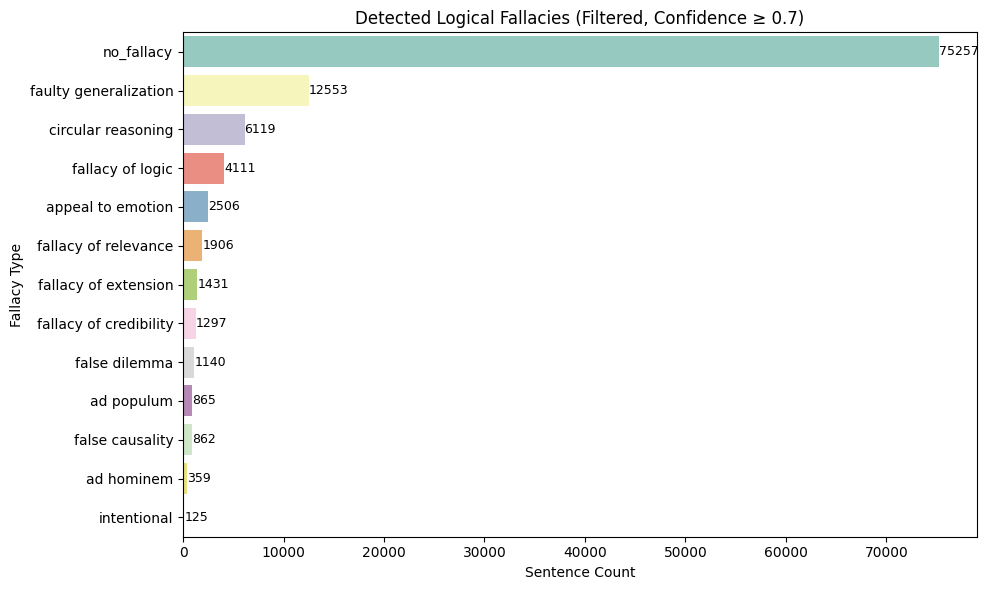

In [40]:
# Plot bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=fallacy_stats, x="count", y="fallacy", palette="Set3")
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.title("Detected Logical Fallacies (Filtered, Confidence ≥ 0.7)")
plt.xlabel("Sentence Count")
plt.ylabel("Fallacy Type")
plt.tight_layout()
plt.show()

In [41]:
# Save filtered dataset
output_path = "2_processed_data/processed_dataset_fallacies_validated.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"Filtered fallacy-labelled data saved to: {output_path}")

Filtered fallacy-labelled data saved to: 2_processed_data/processed_dataset_fallacies_validated.csv


Sampling for Argument Type Labelling for Transfer Learning

In [42]:
df = final_df.copy()

# Count sentence count per transcript
file_counts = df.groupby(["filename", "stance"]).size().reset_index(name="sentence_count")

# Filter for transcripts with sentence count between 25 and 35
valid_files = file_counts[(file_counts["sentence_count"] >= 25) & (file_counts["sentence_count"] <= 35)]

# Select first 75 pro and first 75 con
pro_files = valid_files[valid_files["stance"] == "pro"].head(75)["filename"]
con_files = valid_files[valid_files["stance"] == "con"].head(75)["filename"]

# Combine selected filenames
selected_files = pd.concat([pro_files, con_files])

# Filter original dataset to only selected files
selected_debates_df = df[df["filename"].isin(selected_files)]

# Keep only necessary columns
selected_debates_df = selected_debates_df[["filename", "sentence", "sentence_order"]]

# Add empty columns for manual labeling
selected_debates_df["argument_type"] = ""
selected_debates_df["rationale"] = ""

df.head()

,filename,stance,sentence,sentence_length,sentence_order
0,DJ_121_ban-boxing_pro.trs.txt,pro,We should ban boxing because boxing is a blood...,26,1
1,DJ_121_ban-boxing_pro.trs.txt,pro,So why is this true?,5,2
2,DJ_121_ban-boxing_pro.trs.txt,pro,The first big thing is that boxing has horrifi...,17,3
3,DJ_121_ban-boxing_pro.trs.txt,pro,It's essentially like a modern day equivalent ...,16,4
4,DJ_121_ban-boxing_pro.trs.txt,pro,In the short term you see things like concussi...,32,5


In [43]:
# Save final sampling dataset
output_path = "2_processed_data/sampling.csv"
selected_debates_df.to_csv(output_path, index=False)
print(f"Saved sampling dataset to: {output_path}")

Saved sampling dataset to: 2_processed_data/sampling.csv
